In [25]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split
import categories
import helper_function
# import pillow

In [172]:
imsize = 64
annotation = pd.read_csv("train/Annotations/train.csv")

In [3]:
"""
预处理小于 512*512图片
pad 补丁让 图片 为512* 512
并且让更新坐标
宽度为 shapep[1] 高度为 shape[0]
"""


#写入每张图片size
def write_img_size(df , file_dir ="train/"):
    #width : shape[0] height shape[1]
    size = pd.DataFrame(columns=["width" , "height"])
    max_width=10000
    max_height=10000
    min_width=0
    max_width=0
    for idx,row in df.iterrows():
        filepath_test = file_dir+row['image_id']
        img = Image.open(filepath_test)
        img = np.array(img)
        size.loc[idx]=[img.shape[0],img.shape[1]]
#         wid.set_value(id, img.shape[0])
#         height[idx] = img.shape[1]
    return size

def pad_img(np_img , size = 512):
    wid_diff = size-np_img.shape[1]
    height_diff = size - np_img.shape[0]
    left = int(wid_diff/2)
    right = size-left-np_img.shape[1]
    up = int(height_diff/2)
    down = size-up- np_img.shape[0]
    
    img_pad = np.pad(np_img , ((up,down),(left,right),(0,0)) , 'constant',constant_values=0)
    
    return img_pad,left,up


def pad_images(df,size = 512 , pre_path = 'train/'):
    
    l_m_columns = df.columns.drop(['image_id' , 'image_category'])
    for idx,row in df.iterrows():
        
        filepath = pre_path+row['image_id']
        img = Image.open(filepath)
        np_img = np.array(img)
        if np_img.shape[0] < size or np_img.shape[1] < size:
            print("need padding id: ",idx)
            (np_img,left,up) = pad_img(np_img , size)
            img = Image.fromarray(np_img, 'RGB')
#             img.save(str(idx)+".jpg")
            img.save(filepath)
            for col in l_m_columns:
                coord_list = row[col].split('_')
                coord_list = list(map(int,coord_list))
                
                if coord_list[0] != -1:
#                     print(coord_list)
                    #更新padding后的坐标
                    coord_list[0] +=left
                    coord_list[1] +=up
                    coord_list = list(map(str,coord_list))
                    coord_list = '_'.join(coord_list)
                    df.loc[idx,col] = coord_list
#                     print(coord_list)

    return df



In [ ]:
"""
pad train dataset
"""
pre_path = "train_pad/"
intput_file_name = "Annotations/train.csv"
output_file_name = "Annotations/train_pad.csv"

data_small_eg = pd.read_csv(pre_path + intput_file_name)
data_small_pad = pad_images(data_small_eg,pre_path=pre_path)
data_small_pad.to_csv(pre_path + output_file_name,index=False)

In [5]:
"""
pad warm up dataset
"""
pre_path = "train_warm_up_pad/"
intput_file_name = "Annotations/annotations.csv"
output_file_name = "Annotations/train_pad.csv"

data_small_eg = pd.read_csv(pre_path + intput_file_name)
data_small_pad = pad_images(data_small_eg,pre_path=pre_path)
data_small_pad.to_csv(pre_path + output_file_name,index=False)

need padding id:  9
need padding id:  14
need padding id:  15
need padding id:  30
need padding id:  35
need padding id:  36
need padding id:  39
need padding id:  50
need padding id:  52
need padding id:  56
need padding id:  59
need padding id:  62
need padding id:  67
need padding id:  71
need padding id:  72
need padding id:  85
need padding id:  87
need padding id:  89
need padding id:  92
need padding id:  97
need padding id:  98
need padding id:  99
need padding id:  101
need padding id:  105
need padding id:  109
need padding id:  111
need padding id:  114
need padding id:  115
need padding id:  120
need padding id:  122
need padding id:  123
need padding id:  124
need padding id:  129
need padding id:  135
need padding id:  136
need padding id:  142
need padding id:  146
need padding id:  150
need padding id:  152
need padding id:  153
need padding id:  155
need padding id:  160
need padding id:  163
need padding id:  165
need padding id:  172
need padding id:  178
need paddin

need padding id:  1653
need padding id:  1656
need padding id:  1661
need padding id:  1662
need padding id:  1665
need padding id:  1667
need padding id:  1668
need padding id:  1670
need padding id:  1671
need padding id:  1673
need padding id:  1676
need padding id:  1682
need padding id:  1687
need padding id:  1692
need padding id:  1696
need padding id:  1700
need padding id:  1703
need padding id:  1704
need padding id:  1705
need padding id:  1707
need padding id:  1709
need padding id:  1716
need padding id:  1717
need padding id:  1729
need padding id:  1735
need padding id:  1738
need padding id:  1748
need padding id:  1756
need padding id:  1757
need padding id:  1759
need padding id:  1767
need padding id:  1771
need padding id:  1772
need padding id:  1774
need padding id:  1775
need padding id:  1779
need padding id:  1789
need padding id:  1795
need padding id:  1799
need padding id:  1803
need padding id:  1819
need padding id:  1826
need padding id:  1837
need paddin

need padding id:  3116
need padding id:  3118
need padding id:  3120
need padding id:  3122
need padding id:  3124
need padding id:  3125
need padding id:  3127
need padding id:  3130
need padding id:  3131
need padding id:  3135
need padding id:  3136
need padding id:  3139
need padding id:  3142
need padding id:  3144
need padding id:  3145
need padding id:  3148
need padding id:  3149
need padding id:  3153
need padding id:  3155
need padding id:  3157
need padding id:  3160
need padding id:  3163
need padding id:  3165
need padding id:  3166
need padding id:  3171
need padding id:  3172
need padding id:  3173
need padding id:  3175
need padding id:  3179
need padding id:  3180
need padding id:  3181
need padding id:  3182
need padding id:  3184
need padding id:  3185
need padding id:  3189
need padding id:  3192
need padding id:  3193
need padding id:  3194
need padding id:  3195
need padding id:  3202
need padding id:  3214
need padding id:  3216
need padding id:  3217
need paddin

need padding id:  4082
need padding id:  4083
need padding id:  4085
need padding id:  4086
need padding id:  4087
need padding id:  4088
need padding id:  4090
need padding id:  4091
need padding id:  4094
need padding id:  4097
need padding id:  4099
need padding id:  4100
need padding id:  4102
need padding id:  4105
need padding id:  4106
need padding id:  4110
need padding id:  4111
need padding id:  4114
need padding id:  4115
need padding id:  4116
need padding id:  4119
need padding id:  4122
need padding id:  4123
need padding id:  4127
need padding id:  4128
need padding id:  4130
need padding id:  4131
need padding id:  4137
need padding id:  4138
need padding id:  4144
need padding id:  4150
need padding id:  4151
need padding id:  4155
need padding id:  4158
need padding id:  4166
need padding id:  4167
need padding id:  4170
need padding id:  4178
need padding id:  4181
need padding id:  4182
need padding id:  4184
need padding id:  4185
need padding id:  4186
need paddin

need padding id:  5067
need padding id:  5069
need padding id:  5070
need padding id:  5072
need padding id:  5073
need padding id:  5075
need padding id:  5078
need padding id:  5079
need padding id:  5080
need padding id:  5081
need padding id:  5086
need padding id:  5087
need padding id:  5091
need padding id:  5093
need padding id:  5098
need padding id:  5099
need padding id:  5100
need padding id:  5102
need padding id:  5110
need padding id:  5111
need padding id:  5116
need padding id:  5118
need padding id:  5134
need padding id:  5138
need padding id:  5144
need padding id:  5147
need padding id:  5155
need padding id:  5160
need padding id:  5164
need padding id:  5167
need padding id:  5168
need padding id:  5172
need padding id:  5178
need padding id:  5189
need padding id:  5194
need padding id:  5195
need padding id:  5196
need padding id:  5199
need padding id:  5201
need padding id:  5203
need padding id:  5204
need padding id:  5207
need padding id:  5211
need paddin

need padding id:  6249
need padding id:  6250
need padding id:  6255
need padding id:  6256
need padding id:  6257
need padding id:  6266
need padding id:  6267
need padding id:  6269
need padding id:  6275
need padding id:  6278
need padding id:  6282
need padding id:  6284
need padding id:  6286
need padding id:  6291
need padding id:  6295
need padding id:  6303
need padding id:  6305
need padding id:  6310
need padding id:  6311
need padding id:  6316
need padding id:  6318
need padding id:  6322
need padding id:  6327
need padding id:  6330
need padding id:  6332
need padding id:  6334
need padding id:  6340
need padding id:  6342
need padding id:  6343
need padding id:  6345
need padding id:  6352
need padding id:  6354
need padding id:  6356
need padding id:  6357
need padding id:  6361
need padding id:  6364
need padding id:  6370
need padding id:  6375
need padding id:  6376
need padding id:  6383
need padding id:  6388
need padding id:  6389
need padding id:  6391
need paddin

need padding id:  7519
need padding id:  7530
need padding id:  7532
need padding id:  7535
need padding id:  7537
need padding id:  7539
need padding id:  7547
need padding id:  7548
need padding id:  7554
need padding id:  7555
need padding id:  7556
need padding id:  7560
need padding id:  7561
need padding id:  7564
need padding id:  7566
need padding id:  7569
need padding id:  7571
need padding id:  7576
need padding id:  7594
need padding id:  7598
need padding id:  7603
need padding id:  7605
need padding id:  7610
need padding id:  7611
need padding id:  7613
need padding id:  7615
need padding id:  7616
need padding id:  7619
need padding id:  7620
need padding id:  7621
need padding id:  7623
need padding id:  7624
need padding id:  7625
need padding id:  7635
need padding id:  7643
need padding id:  7657
need padding id:  7659
need padding id:  7660
need padding id:  7662
need padding id:  7666
need padding id:  7667
need padding id:  7674
need padding id:  7675
need paddin

need padding id:  9942
need padding id:  9944
need padding id:  9945
need padding id:  9946
need padding id:  9948
need padding id:  9949
need padding id:  9953
need padding id:  9956
need padding id:  9960
need padding id:  9964
need padding id:  9969
need padding id:  9971
need padding id:  9973
need padding id:  9984
need padding id:  9985
need padding id:  9987
need padding id:  9994
need padding id:  10000
need padding id:  10001
need padding id:  10008
need padding id:  10009
need padding id:  10010
need padding id:  10016
need padding id:  10022
need padding id:  10025
need padding id:  10029
need padding id:  10033
need padding id:  10034
need padding id:  10036
need padding id:  10040
need padding id:  10045
need padding id:  10048
need padding id:  10049
need padding id:  10051
need padding id:  10053
need padding id:  10055
need padding id:  10061
need padding id:  10063
need padding id:  10068
need padding id:  10069
need padding id:  10076
need padding id:  10078
need padd

need padding id:  10885
need padding id:  10894
need padding id:  10898
need padding id:  10909
need padding id:  10910
need padding id:  10911
need padding id:  10912
need padding id:  10916
need padding id:  10920
need padding id:  10923
need padding id:  10927
need padding id:  10928
need padding id:  10930
need padding id:  10931
need padding id:  10938
need padding id:  10939
need padding id:  10942
need padding id:  10950
need padding id:  10953
need padding id:  10956
need padding id:  10959
need padding id:  10961
need padding id:  10969
need padding id:  10973
need padding id:  10974
need padding id:  10976
need padding id:  10981
need padding id:  10983
need padding id:  10985
need padding id:  10986
need padding id:  10987
need padding id:  10990
need padding id:  10992
need padding id:  10994
need padding id:  10996
need padding id:  10997
need padding id:  11000
need padding id:  11002
need padding id:  11003
need padding id:  11006
need padding id:  11008
need padding id:

need padding id:  11745
need padding id:  11747
need padding id:  11748
need padding id:  11750
need padding id:  11759
need padding id:  11760
need padding id:  11761
need padding id:  11762
need padding id:  11766
need padding id:  11767
need padding id:  11770
need padding id:  11771
need padding id:  11772
need padding id:  11774
need padding id:  11775
need padding id:  11776
need padding id:  11778
need padding id:  11783
need padding id:  11784
need padding id:  11785
need padding id:  11791
need padding id:  11793
need padding id:  11794
need padding id:  11796
need padding id:  11798
need padding id:  11799
need padding id:  11800
need padding id:  11803
need padding id:  11804
need padding id:  11806
need padding id:  11809
need padding id:  11810
need padding id:  11814
need padding id:  11815
need padding id:  11819
need padding id:  11824
need padding id:  11825
need padding id:  11826
need padding id:  11831
need padding id:  11835
need padding id:  11836
need padding id:

In [67]:
"""
image augmentation
"""

import os, errno
from random import randint

def mirror_images(df,im_size = 512, pre_path = './train_pad/',mode="mirror"):
    if mode == "mirror":
        #creating folder
        for name in df.image_category.unique():
            try:
                os.makedirs(pre_path+mode+"/"+"Images/"+name)
            except OSError as e:
                if e.errno != errno.EEXIST:
                    raise    
        l_m_columns = df.columns.drop(['image_id' , 'image_category'])
        for idx,row in df.iterrows():
            filepath = pre_path+row['image_id']
            img = Image.open(filepath)
            img =img.transpose(Image.FLIP_LEFT_RIGHT)
            img.save(pre_path+mode+"/"+row['image_id'])
            df.loc[idx,'image_id'] = mode+'/'+row['image_id']
            for col in l_m_columns:
                coord_list = row[col].split('_')
                coord_list = list(map(int,coord_list))

                if coord_list[0] != -1:
    #                     print(coord_list)
                    #更新padding后的坐标
                    coord_list[0] =im_size - coord_list[0]
    #                 coord_list[1] =512 - coord_list[1]
                    coord_list = list(map(str,coord_list))
                    coord_list = '_'.join(coord_list)
                    df.loc[idx,col] = coord_list
#                     print(coord_list)
    if mode == "crop":
                #creating folder
        for name in df.image_category.unique():
            try:
                os.makedirs(pre_path+mode+"/"+"Images/"+name)
            except OSError as e:
                if e.errno != errno.EEXIST:
                    raise    
        l_m_columns = df.columns.drop(['image_id' , 'image_category'])
        for idx,row in df.iterrows():
            #every images
            #find the max and min width and height of LANDMARKS
            max_wid=0
            min_wid=im_size+1
            max_h=0
            min_h=im_size+1
            for col in l_m_columns:
                coord_list = row[col].split('_')
                coord_list = list(map(int,coord_list))
                if coord_list[0] != -1:
    #                     print(coord_list)
                    #更新padding后的坐标
                    max_wid = max(max_wid ,coord_list[0] )
                    min_wid = min(min_wid ,coord_list[0] )
                    max_h = max(max_h ,coord_list[1] )
                    min_h = min(min_h ,coord_list[1] )    
            edge=5        
            left = randint(0,min_wid-edge)
            right = randint(max_wid+edge,im_size)
            up= randint(0,min_h - edge)
            down= randint(max_h + edge , im_size)
            filepath = pre_path+row['image_id']
            img = Image.open(filepath)
            img = img.crop(
                (
                    left,
                    up,
                    right,
                    down
                )
            )
            horizontal_padding = int((im_size - img.size[0]) / 2)
            vertical_padding = int((im_size - img.size[1]) / 2)

            img = img.crop(
                (
                    -horizontal_padding,
                    -vertical_padding,
                    img.size[0] + im_size - horizontal_padding,
                    img.size[1] + im_size - vertical_padding
                )
            )
            
            
            img.save(pre_path+mode+"/"+row['image_id'])
            df.loc[idx,'image_id'] = mode+'/'+row['image_id']

        
    return df
pre_path = "train_pad/"
intput_file_name = "Annotations/train_pad.csv"
output_file_name = "Annotations/train_pad_mirror.csv"

data= pd.read_csv(pre_path + intput_file_name)
data = mirror_images(data[:10],mode="crop")
data.to_csv(pre_path + output_file_name,index=False)

# img = Image.open("a.jpg")
# img =img.transpose(Image.FLIP_LEFT_RIGHT)
# plt.imshow(img)

398 101 380 130
95 480 73 421
(385, 348)
334 200 276 110
44 455 5 398
(411, 393)


C:\Users\csyic\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\csyic\Anaconda3\lib\site-packages\ipykernel_launcher.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


310 173 399 157
149 476 126 504
(327, 378)
355 139 369 154
46 413 99 436
(367, 337)
384 89 464 169
67 509 70 496
(442, 426)
338 158 335 137
40 372 132 493
(332, 361)
369 165 391 127
13 418 122 455
(405, 333)
368 128 347 7
17 478 1 412
(461, 411)
380 119 344 131
87 442 51 361
(355, 310)
335 121 387 230
33 505 24 461
(472, 437)


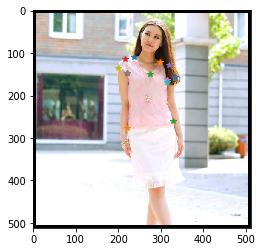

In [41]:
data_input= pd.read_csv(pre_path + intput_file_name)
# helper_function.show_im_lms(data, 1,1,pre_dir="train_pad/")
helper_function.show_im_lms(data_input, 1,1,pre_dir="train_pad/")

0.0 106.0
(512, 300)
(512, 512)


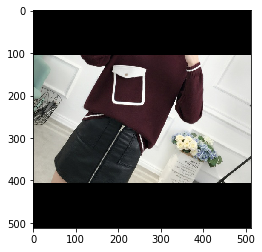

In [59]:
img = Image.open("a.jpg")
width = img.size[0]
height = img.size[1]
img3 = img.crop(
    (
        0,
        height - 300,
        width,
        height
    )
)



longer_side = max(img3.size)
horizontal_padding = (512 - img3.size[0]) / 2
vertical_padding = (512 - img3.size[1]) / 2

print(horizontal_padding,vertical_padding)
print(img3.size)
img5 = img3.crop(
    (
        -horizontal_padding,
        -vertical_padding,
        img3.size[0] + horizontal_padding,
        img3.size[1] + vertical_padding
    )
)
print(img5.size)
plt.imshow(img5)

In [23]:
"""
data_augmentation
"""

pre_path = "train_pad/"
intput_file_name = "Annotations/train.csv"
output_file_name = "Annotations/train_pad.csv"

data_pad = pd.read_csv(pre_path + intput_file_name)
test = data_pad[["image_id","image_category"]][0:4]
test2 =pd.DataFrame(np.arange(8).reshape([4,-1]))
pd.concat([test,test2] , axis=1)

,image_id,image_category,0,1
0,Images/blouse/3578977274375a7ab75862852210b5f5...,blouse,0,1
1,Images/blouse/524eb709a171eab14598860253023d62...,blouse,2,3
2,Images/blouse/72e09104ad0d46d59379b32197a14d64...,blouse,4,5
3,Images/blouse/ff068d86d60181edea224ffb16d1dbe8...,blouse,6,7


In [42]:
"""
将数据分类别
"""




#通过不同的类型写入
def write_with_category(df , is_train=True , pre_path="train/"):
    write_path = pre_path+"Annotations/train_"
    categories = df.image_category.unique()
    for category in categories:
        df_new = df.loc[df.image_category==category,:]
        df_new.to_csv(write_path+category+".csv",index =False)
        
pre_path = "train_pad/"
intput_file_name =  "Annotations/train_pad.csv"

data_pad = pd.read_csv(pre_path + intput_file_name)
write_with_category(data_pad,pre_path=pre_path)

pre_path = "train_warm_up_pad/"
intput_file_name =  "Annotations/train_pad.csv"
data_pad = pd.read_csv(pre_path + intput_file_name)
write_with_category(data_pad,pre_path=pre_path)

In [409]:
"""
将数据分隔为x y visbile
"""
cates = ["blouse" ,"outwear","trousers","skirt","dress" ]
pre_path = "train_pad/"
#输入原来数据结构
#输出分解后的坐标
def split_coord(df ,cate, output_path):
    columns = df.columns
    if "height" in columns or "width" in columns:
        l_m_columns = columns.drop(['image_id' , 'image_category','height','width'])
    else:
        l_m_columns = columns.drop(['image_id' , 'image_category'])
    cols = categories.get_columns(idx)
    for col in cols:
        coord_list = df[col].str.split('_')
        #if int(coord_list[0][1]) != -1:
        df[[col+"_x" , col+"_y", col+"_vis"]] = pd.DataFrame(coord_list.tolist(), index= df.index)
    df = df.drop(l_m_columns,axis=1)
    df.to_csv( output_path, index = False)
    return df
for idx,cate in enumerate(cates):
    intput_file =  "Annotations/train_"+cate+".csv"
    output_coord_file = pre_path +"Annotations/train_"+cate+"_coord.csv"
    
    data_blouse = pd.read_csv(pre_path + intput_file)
    data_blouse_coord = split_coord(data_blouse,idx,output_coord_file)



In [449]:
"""
将所有坐标都写入 CSV
将数据分隔为x y visbile
"""
cates = ["blouse" ,"outwear","trousers","skirt","dress" ]
pre_path = "train_pad/"
#输入原来数据结构
#输出分解后的坐标
def split_coord(df ,cate, output_path):
    columns = df.columns
    if "height" in columns or "width" in columns:
        l_m_columns = columns.drop(['image_id' , 'image_category','height','width'])
    else:
        l_m_columns = columns.drop(['image_id' , 'image_category'])
#     cols = categories.get_columns(idx)
    for col in l_m_columns:
        coord_list = df[col].str.split('_')
        #if int(coord_list[0][1]) != -1:
        df[[col+"_x" , col+"_y", col+"_vis"]] = pd.DataFrame(coord_list.tolist(), index= df.index)
    df = df.drop(l_m_columns,axis=1)
    df.to_csv( output_path, index = False)
    return df
for idx,cate in enumerate(cates):
    intput_file =  "Annotations/train_"+cate+".csv"
    output_coord_file = pre_path +"Annotations/train_"+cate+"_coord_all.csv"
    
    data_blouse = pd.read_csv(pre_path + intput_file)
    data_blouse_coord = split_coord(data_blouse,idx,output_coord_file)

In [448]:
"""
按不同类型读图片，
并生成为：
x (m, 宽*高*3)
y (m,关键点*3)
"""
pre_path = "train_pad/"
intput_blouse_file =  "Annotations/train_blouse_coord.csv"

#x (m, 宽*高*3)
def set_x_one_hot(df , scale = 1 , folder =  'train/'):
    filepath_test = folder+df.iloc[0,0]
    img = Image.open(filepath_test)
    np_img = np.array(img)
    img = img.resize((int(np_img.shape[1]/scale),int(np_img.shape[0]/scale)))
    x_all =np.expand_dims( np.array(img).reshape((-1)) , axis=0)
    size= df.shape[0]  
    
    for idx,row in df.iterrows():
        filepath_test =folder+row['image_id']
        img = Image.open(filepath_test)
        np_img = np.array(img)
        
        img = img.resize((int(np_img.shape[1]/scale),int(np_img.shape[0]/scale)))
        np_img = np.array(img)
        np_img = np_img.reshape((-1))
        #print(np_img.shape)
#         np.concatenate(x_all,np.array(new_img))
        x_all = np.append(x_all,np.expand_dims(np_img,axis=0),axis=0)
#     print(x_all.shape)
#     x_all=x_all.reshape((size,-1))
#     print(x_all.shape)
#     np.savetxt('images.txt' , x_all)
    return x_all[1:]

# y (m,关键点*3)
def set_y_coord(df,scale = 1):
    columns = df.columns
    if "height" in columns or "width" in columns:
        l_m_columns = columns.drop(['image_id' , 'image_category','height','width'])
    else:
        l_m_columns = columns.drop(['image_id' , 'image_category'])
    y_coord = df[l_m_columns].as_matrix()

    y_coord[:,np.arange(0,y_coord.shape[1],3)] = y_coord[:,np.arange(0,y_coord.shape[1],3)]/scale
    y_coord[:,np.arange(1,y_coord.shape[1],3)] = y_coord[:,np.arange(1,y_coord.shape[1],3)]/scale
    
    l_m_index = np.append(np.arange(0,y_coord.shape[1],3), np.arange(1,y_coord.shape[1],3) )
    l_m_index = np.sort(l_m_index)
    vis_index = np.arange(2,y_coord.shape[1],3)

#     print(np.sort(l_m_index))
    
    # Whether has landmark point
    has_lm_data = y_coord[:,vis_index]
    has_lm_data[has_lm_data==0]=1
    has_lm_data[has_lm_data==-1]=0

    # Whether is visible
    is_vis_data = y_coord[:,vis_index]
    is_vis_data[np.logical_or( is_vis_data ==-1 , is_vis_data==0 )]=0
    
    print (y_coord[:,l_m_index].shape ,has_lm_data.shape , is_vis_data.shape)
    return_array = np.concatenate((y_coord[:,l_m_index],has_lm_data , is_vis_data),axis=1)
    return return_array
    return y_coord[:,l_m_index]


# y (m,关键点*3)


def set_image_name(df):
    return df.loc[:,['image_id' , 'image_category']].as_matrix()
    

data_blouse_coord = pd.read_csv(pre_path + intput_blouse_file)
small_data_blouse_coord = data_blouse_coord.loc[0:9,:] 
x_train = set_x_one_hot(small_data_blouse_coord, 8, pre_path)

y_train = set_y_coord(small_data_blouse_coord  , 1)



print(x_train.shape , y_train.shape,name_train.shape)
y_train[7,:]

# #make small data for 整合各式：
# name_train = set_image_name(small_data_blouse_coord)
# np.append(name_train,y_train,axis=1).shape
# pd.DataFrame(np.append(name_train,y_train,axis=1)).to_csv("test_coord.csv" , index = False)

(10, 26) (10, 13) (10, 13)
(10, 12288) (10, 52) (10, 2)


array([229,  34, 301,  30, 261,  48, 181,  64, 351,  35, 198, 151, 364,
       145, 167, 347, 128, 347, 299,   7,  -1,  -1, 178, 281, 368, 279,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   0,   1,   1,
         1,   0,   1,   1,   0,   0,   1,   1,   1,   1,   0,   0,   1],
      dtype=int64)

# 以下为测试

numpy.ndarray

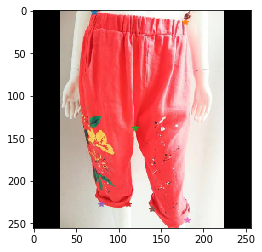

In [376]:

data_pad = pd.read_csv(pre_path + output_file_name)
show_im_lms(data_pad,28172,2,pre_dir=pre_path)


In [323]:

#helper function:

def show_im_lms(df,index,scale=1 , pre_dir = 'train/'):
    #show landmarks
    columns = df.columns
    l_m_columns = columns.drop(['image_id' , 'image_category'])
    for col in l_m_columns:
        coord = df.loc[index,col]
        coord=coord.split('_')
        #change the string into integer
        coord = list(map(float, coord))
        if coord[0]!=-1:
            x=coord[0]/scale
            y=coord[1]/scale
            plt.plot(x,y,'*')
            
    filepath = pre_dir+df.loc[index,'image_id']
    img = Image.open(filepath)
    width = int(np.array(img).shape[1]/scale)
    height = int(np.array(img).shape[0]/scale)
    img = img.resize((width,height))
    plt.imshow(img)
    
def make_small_df(df , size =99):
    category_size = {}
    for idx,cate in enumerate(df.image_category.unique()):
        category_size[cate] = df.loc[df['image_category'] == cate,:].shape[0]
    
    df_result = df.loc[:size,:]
    beg=0
    for name,value in category_size.items():
        #print(name,value)
        beg+=value
        if beg>df.shape[0]:
            break
        df_result=pd.concat([df_result,df.loc[beg:beg+size,:]])
    return df_result.reset_index()
"""

x_onehot (m, wid*height*3)
"""    
def set_y(df):
    #create category encoding
    category_encode = {}
    category_size = {}
    category_array={}
    for idx,cate in enumerate(df.image_category.unique()):
        category_encode[cate] =idx
        category_size[cate] = df.loc[df['image_category'] == cate,:].shape[0]
        #map the category with encoding.
        category_array[cate] = df.loc[df['image_category'] == cate,'image_category'].map(category_encode).as_matrix()
    y_cate = df.image_category
    y_cate=y_cate.map(category_encode)
    return y_cate
"""

x_onehot (m, wid*height*3)
"""  



##########################################






def set_x_one_hot(df , im_size = 128):
    filepath_test = 'train/'+df.loc[0,'image_id']
    img = Image.open(filepath_test)

    new_img = img.resize((im_size,im_size))
    x_all =np.expand_dims( np.array(new_img).reshape((-1)) , axis=0)
    size= df.shape[0]  
    
    for idx,row in df.iterrows():
        filepath_test = 'train/'+row['image_id']
        img = Image.open(filepath_test)
        np_img = np.array(img)
        if np_img.shape[0]!= 512 or np_img.shape[1]!= 512:
            pad_img(np_img)
        
        new_img = img.resize((im_size,im_size))
        np_img = np.array(new_img)
        np_img = np_img.reshape((-1))
        #print(np_img.shape)
#         np.concatenate(x_all,np.array(new_img))
        x_all = np.append(x_all,np.expand_dims(np_img,axis=0),axis=0)
#     print(x_all.shape)
#     x_all=x_all.reshape((size,-1))
#     print(x_all.shape)
#     np.savetxt('images.txt' , x_all)
    return x_all[1:]
#     x_all=x_all.reshape((size,im_size,im_size,3))
#     print(x_all.shape)
#     np.savetxt('images.txt' , x_all)
    #plt.imshow(new_img)
    #np.array(new_img).shape





def update_coord(df,idx, size = 512):
    filepath_test = 'train/'+df.loc[idx,'image_id']
    img = Image.open(filepath_test)
    img = np.array(img)
    
    wid_diff = size-img.shape[0]
    height_diff = size - img.shape[1]
    left = int(wid_diff/2)
    up = int(height_diff/2)
    
    df = df.loc[idx,df.columns.drop(['image_id' , 'image_category','width','height'])]
    
    columns = df.columns
    col_size = columns.shape[0]
    df[columns[np.arange(0,col_size,3)]] = df[columns[np.arange(0,col_size,3)]]+left
    df[columns[np.arange(1,col_size,3)]] = df[columns[np.arange(1,col_size,3)]]+up
    
    print(df[columns[np.arange(0,col_size,3)]].shape)
    return df



    

def get_x_y(df,df_size,scale=1):
    df=df[:df_size]
    
    x=set_x_one_hot(df,imsize)
    y=set_y_coord(data_train_blouse_split)

In [187]:
#将图片size加入数据结构
train_data = pd.read_csv("train/Annotations/train.csv")
train_size = pd.read_csv("train_size.csv")
train_data[["width" ,"height"]] = train_size[["width" ,"height"]]
train_data.to_csv("train/Annotations/train_with_size.csv",index =False)


test_data= pd.read_csv("test/test.csv")
test_size = pd.read_csv("test_size.csv")
test_data[["width" ,"height"]] = test_size[["width" ,"height"]]
test_data.to_csv("test/test_with_size.csv",index =False)



In [188]:
write_with_category(train_data)

In [200]:
#write blouse的坐标系
data_train_blouse = pd.read_csv("train/Annotations/train_blouse.csv")
data_train_blouse = clean_columns(data_train_blouse,1)
data_train_blouse_split = split_coord(data_train_blouse)
data_train_blouse_split.to_csv("train/Annotations/train_blouse_coord.csv" , index = False)

In [232]:
set_x_one_hot(data_train_blouse_split[:100]).shape
# set_y_coord(data_train_blouse_split)

(100, 49152)

In [240]:
update_coord(data_train_blouse_split,1)

AttributeError: 'Series' object has no attribute 'columns'

In [231]:
# x_all  = np.array([])
# set_x_one_hot(annotation).
small_df = make_small_df(annotation)
x_one_hot = set_x_one_hot(small_df,imsize)


In [266]:
y_cate = set_y(small_df)
y_cate.shape
y_cate=pd.get_dummies(y_cate).as_matrix()


In [267]:
import sklearn.model_selection as sk

X_train, X_test, y_train, y_test = sk.train_test_split(x_one_hot,y_cate,test_size=0.33, random_state = 42)
X_train.shape
y_train.shape

(335, 5)

In [251]:
enc = OneHotEncoder()
enc.fit([[1,2,3]])

OneHotEncoder(categorical_features='all', dtype=<class 'numpy.float64'>,
       handle_unknown='error', n_values='auto', sparse=True)

In [44]:
filepath_test = 'train/'+annotation.loc[0,'image_id']

print(annotation.shape)
annotation.head()
# type(annotation)

l_m_columns = columns.drop(['image_id' , 'image_category'])
test = annotation.loc[0,l_m_columns]
print(test.shape)
test.str.split('_')
type(test.str.split('_').as_matrix())
test.str.split('_').as_matrix()

(31631, 26)


NameError: name 'columns' is not defined

In [45]:
im = imageio.imread(filepath_test)

512


<function Image.resize>

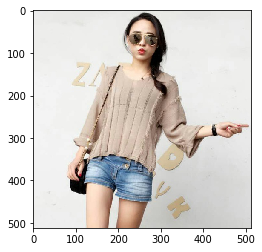

In [46]:
print(im.shape[0])
plt.imshow(im)
im.resize

In [47]:
min_wid = 600
min_len = 600
for idx ,row in annotation.iterrows():
    filepath_test = 'train/'+row['image_id']
    im = imageio.imread(filepath_test)
    min_wid = min(min_wid,im.shape[0])
    min_len = min(min_len,im.shape[1])
print(min_wid , min_len)

KeyboardInterrupt: 

(612, 612, 3)

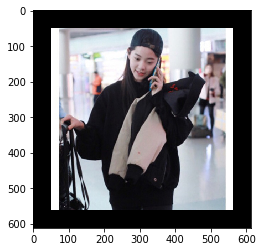

In [242]:
#resize image

img = Image.open(filepath_test)
# new_img = img.resize((1700,200))

img.save("a.jpg")
# plt.imshow(new_img)
img = np.array(img)
img.shape

img_pad = np.pad(img , ((50,50),(50,50),(0,0)) , 'constant')
plt.imshow(img_pad)
img_pad.shape


In [356]:
img = Image.open("a.png")
np.array(img).shape

(257, 221)